### 21COC102 - Advanced AI Systems

#### Coursework Submission - Joe Cunningham

The purpose of this coursework is to demonstrate different deep neural network architectures on an image classification
problem.

The dataset used in this project is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), comprising 60000 3x32x32
images with 10 classes

In [187]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

# I have gpu access for training, but models should be compatible with CPU
# Hence, check for a GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Until i figure out if there is a Dataset attrib. for this, this will do....
NUM_CLASSES = 10
CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Download the CIFAR-10 dataset & create dataloaders. Adapted from the pytorch quickstart guide
[\[1\]](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [113]:
CIFAR_train = datasets.CIFAR10(
    root = 'CIFAR-10',
    train = True,
    transform = ToTensor(),
    download=True
)

CIFAR_test = datasets.CIFAR10(
    root = 'CIFAR-10',
    train = False,
    transform = ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [114]:
batch_size = 64

train_dataloader = DataLoader(CIFAR_train, batch_size=batch_size)
test_dataloader = DataLoader(CIFAR_test, batch_size=batch_size)

### Fully Connected Neural Networks

The first type of neural network to experiment with is the fully connected network. This network comprises several 1-D
layers of neurons, where every neuron in one layer is connected to every neuron in the following layer. The following
network, `FullyConnectedNetwork`, has an input layer of 3072 neurons, two hidden layers of 512 neurons each, with a
final output/classification layer of 10 neurons. An activation function is placed between each layer to introduce
non-linearity.

Adapted from the pytorch quickstart guide
[\[1\]](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [185]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, config:dict):
        super(FullyConnectedNetwork, self).__init__()
        self.name = config['name']

        self.flatten = nn.Flatten()

        layers = config['layer_sizes']
        act_func = config['activation_function']
        batch_norm = config['batch_norm']

        self.linear_stack = nn.Sequential()
        for i in range(len(layers)-1):
            self.linear_stack.append(nn.Linear(layers[i][0],layers[i][1]))
            if batch_norm: self.linear_stack.append(nn.BatchNorm1d(layers[i][1]))
            self.linear_stack.append(act_func)
        # Add last layer without a following activation function
        self.linear_stack.append(nn.Linear(layers[-1][0], layers[-1][1]))


    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_stack(x)
        return x

fc_net_config = {
    'name' : 'FullyConnectedNetwork_1x128',
    'layer_sizes' : [(3*32*32,128),(128,128),(128,10)],
    'activation_function' : nn.ReLU(),
    'batch_norm' : True
}
fc_net = FullyConnectedNetwork(fc_net_config).to(device)
print(fc_net)

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [183]:
#Setup model evaluation functions
def compute_confusion_matrix(pred_classes, gt_classes, num_classes):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for i in range(pred_classes.shape[0]):
        confusion_matrix[pred_classes[i],gt_classes[i]] += 1
    return confusion_matrix

def compute_precision_recall(confusion_matrix, print_output=False):
    num_classes = confusion_matrix.shape[0]
    class_precision_recall = torch.zeros(num_classes,2)
    for i in range(num_classes):
        true_pos = confusion_matrix[i,i]
        precision = true_pos / confusion_matrix[i,:].sum()
        recall = true_pos / confusion_matrix[:,i].sum()
        class_precision_recall[i,0] = precision
        class_precision_recall[i,1] = recall
        if print_output: print(f"Class: {i}, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}")
    avg_precision = class_precision_recall[:,0].sum()/num_classes
    avg_recall = class_precision_recall[:,1].sum()/num_classes
    if print_output: print(f"Average Precision: {avg_precision*100:.2f}%, Average Recall: {avg_recall*100:.2f}%")
    return class_precision_recall, avg_precision, avg_recall


# Setup training/test functions
# Adapted from the pytorch quickstart guide
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimiser:torch.optim.Optimizer):
    size = len(dataloader.dataset)
    train_loss = 0 # For graphing the change in loss over time
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute preds and loss for batch
        preds = model(X)
        loss = loss_fn(preds,y)

        #Backprop
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss = loss.item()
        train_loss += loss * len(X) #Weight the average to account for the last batch

        #Progress tracking
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= size
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    # we will compute a confusion matrix to allow for calculation of
    confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
    with torch.no_grad():
        for X, y in dataloader:
            X, y, = X.to(device), y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds, y).item()
            pred_classes = preds.argmax(1)
            confusion_matrix += compute_confusion_matrix(pred_classes, y, NUM_CLASSES)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    class_precision_recall, avg_precision, avg_recall = compute_precision_recall(confusion_matrix, print_output=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return [test_loss, correct, confusion_matrix, class_precision_recall,avg_precision, avg_recall]


In [186]:
# Run the test a training loops for 5 epochs

def train_with_early_stopping(train_dataloader, test_dataloader, model, loss_fn, optimiser, save_interval=2, min_epochs=2):

    stop, epoch = False, 1
    train_losses = []
    test_results = []
    test_losses = []
    while not stop:
        print(f"---------- Epoch {epoch} ---------")
        train_losses.append(train(train_dataloader, model, loss_fn, optimiser)) #Train
        test_result = test(test_dataloader, model, loss_fn) #Test
        # Compile test results
        test_results.append(test_result)
        test_losses.append(test_result[0])

        #Save model
        if epoch % save_interval == 0:
            filename = f"{model.name}_{epoch}.pth"
            torch.save(model.state_dict(), filename)

        #check if current test loss is worse than last 2 epochs
        if epoch > min_epochs and epoch > 2:
            check1 = test_losses[-1] > test_losses[-2]
            check2 = test_losses[-1] > test_losses[-3]
            if check1 and check2:
                stop = True
                print(f"Early stopping triggered at epoch {epoch}. Done!")
        # next epoch
        epoch += 1
    return train_losses, test_results

# Train a model

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(fc_net.parameters(), lr=1e-1)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, fc_net, loss_fn, optimiser)

---------- Epoch 1 ---------
loss: 2.386367  [    0/50000]
loss: 1.709794  [ 6400/50000]
loss: 1.411236  [12800/50000]
loss: 1.799638  [19200/50000]
loss: 1.648958  [25600/50000]
loss: 1.736743  [32000/50000]
loss: 1.619795  [38400/50000]


KeyboardInterrupt: 

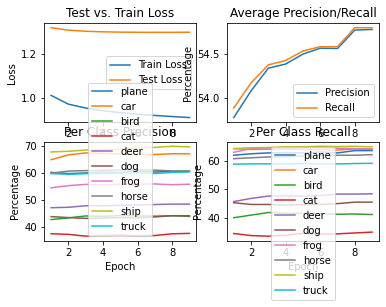

In [192]:
# Plot the results of a training session using pyplotlib
# Currently plotting the following:
#  - Training loss vs Test loss
#  - Average precision, recall, and accuracy (test set)
#  - Precision per class
#  - Recall per class
def plot_results(train_losses, test_results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    # Plot TrainLoss on ax1
    xs, ys = [], []
    for epoch, loss in enumerate(train_losses):
        xs.append(epoch+1)
        ys.append(loss)

    ax1.plot(xs, ys, label="Train Loss")

    # Plot TestLoss on ax1
    test_losses = [i[0] for i in test_results]
    xs, ys = [], []
    for epoch, loss in enumerate(test_losses):
        xs.append(epoch+1)
        ys.append(loss)
    ax1.plot(xs, ys, label="Test Loss")

    # Setup ax1 to show test vs train loss
    ax1.legend()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Test vs. Train Loss")

    # Plot avg precision (ax2)
    ys = [i[4]*100 for i in test_results]
    ax2.plot(xs, ys, label='Precision')

    # Plot avg recall (ax2)
    ys = [i[5]*100 for i in test_results]
    ax2.plot(xs, ys, label='Recall')

    # Setup ax2
    ax2.legend()
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Percentage")
    ax2.set_title("Average Precision/Recall")

    # Show per class precision/recall (ax3/4)
    precision_recalls = [i[3] for i in test_results]
    xs = [i+1 for i in range(len(precision_recalls))]
    for idx, class_name in enumerate(CLASS_NAMES):
        ys_p, ys_r = [],[]
        for p_r in precision_recalls:
            ys_p.append(p_r[idx, 0]*100)
            ys_r.append(p_r[idx, 1]*100)
        # Precision on ax3, recall on ax4
        ax3.plot(xs, ys_p, label=class_name)
        ax4.plot(xs, ys_r, label=class_name)
    # Setup ax3,4
    ax3.legend()
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Percentage")
    ax3.set_title("Per Class Precision")
    ax4.legend()
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Percentage")
    ax4.set_title("Per Class Recall")



plot_results(train_losses, test_results)




### Convolutional Neural Networks

The first network is based on AlexNet, but scaled down to a 32x32 input

In [203]:
class JoeNet(nn.Module):
    def __init__(self, config:dict):
        super(JoeNet, self).__init__()
        self.name = config['name']
        self.batch_norm = config['batch_norm']

        self.conv1 = nn.Conv2d(3, 24, 7, 2) #32x32 -> 13x13
        self.conv1_bn = nn.BatchNorm2d(24)
        self.pool1 = nn.MaxPool2d(3, 1, padding=1) #13x13 -> 13x13
        self.conv2 = nn.Conv2d(24,64,5,padding="same") #13x13 -> 13x13
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 1) #13x13 -> 12x12
        self.conv3 = nn.Conv2d(64, 96, 3, padding="same")
        self.conv3_bn = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 96, 3, padding="same")
        self.conv4_bn = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 64, 3, padding="same")
        self.conv5_bn = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, stride=2)
        self.fc1 = nn.Linear(1600, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(1024, 1024)
        self.fc2_bn = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x)) if self.batch_norm else F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x)) if self.batch_norm else F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x)) if self.batch_norm else F.relu(x)
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x)) if self.batch_norm else F.relu(x)
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x)) if self.batch_norm else F.relu(x)
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x)) if self.batch_norm else F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(self.fc2_bn(x)) if self.batch_norm else F.relu(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

jn_config = {
    'name' : 'JoeNet_test',
    'batch_norm' : False
}

j_net = JoeNet(jn_config)
j_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(j_net.parameters(), lr=1e-3)

print(j_net)

train_losses, test_results = train_with_early_stopping(train_dataloader, test_dataloader, j_net, loss_fn, optimiser)

JoeNet(
  (conv1): Conv2d(3, 24, kernel_size=(7, 7), stride=(2, 2))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

KeyboardInterrupt: 